In [1]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [2]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [3]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft = 1024, hop_length = 512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft = n_fft,
        hop_length = hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [4]:
def read_data(src_dir, genres, song_samples, spec_format, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                if len(signal) < song_samples:
                    print('Error in {}\nNum of samples ( >= {}): {}'.format(file_name, song_samples, len(signal)))
                signal = signal[:song_samples]
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Convert to dataset of spectograms/melspectograms
                signals, y = splitsongs(signal, genres[x])
                
                # Convert to "spec" representation
                specs = spec_format(signals)
                
                # Save files
                arr_genres.extend(y)
                arr_specs.extend(specs)
                
                
    return np.array(arr_specs), np.array(arr_genres)

In [5]:
# Parameters
gtzan_dir = 'A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [6]:
# Read the data
X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=True)
np.save('A:/TechieYan projects/AI/Identifying_Music_Genre/data/x_gtzan_npy.npy', X)
np.save('A:/TechieYan projects/AI/Identifying_Music_Genre/data/y_gtzan_npy.npy', y)

Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00000.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00001.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00002.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00003.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00004.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00005.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00006.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00007.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00008.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/metal.00009.au
Reading file: A:/TechieYan projects/AI/Identifying_Music_Genre/gtzan_2/metal/met

In [10]:
X = np.load(r'A:/TechieYan projects/AI/Identifying_Music_Genre/data/x_gtzan_npy.npy')
y = np.load(r'A:/TechieYan projects/AI/Identifying_Music_Genre/data/y_gtzan_npy.npy')

In [11]:
print(y)

[0 0 0 ... 9 9 9]


In [12]:
# One hot encoding of the labels
y = to_categorical(y)

# Dataset Split

In [13]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.3, random_state=42, stratify = y)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6796, 128, 129, 3) (2913, 128, 129, 3) (6796, 10) (2913, 10)


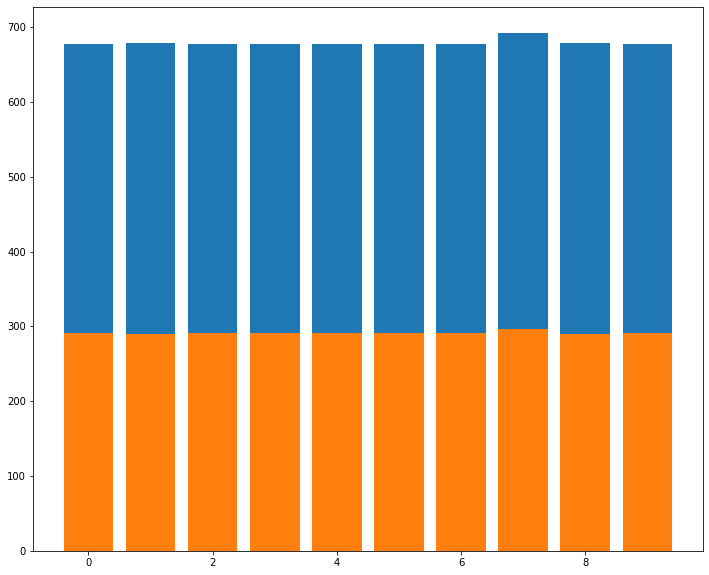

In [ ]:
# Histogram for train and test 
plt.figure(figsize =(12,10))

values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Training

In [ ]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(256, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 5)
print("Creating EarlyStopping Callback ...")
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)
model.summary()

58900480/58889256 [==============================] - 2s 0us/step
Creating EarlyStopping Callback ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 129, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 129, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                          

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="Adam",
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=128,
          epochs=50,
          verbose=1,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[early_stopping_callback])
print("Learning stoped on epoch:", early_stopping_callback.stopped_epoch)

Epoch 1/50
54/54 [==============================] - 72s 976ms/step - loss: 2.3939 - accuracy: 0.2222 - val_loss: 1.7756 - val_accuracy: 0.3659
Epoch 2/50
54/54 [==============================] - 46s 860ms/step - loss: 1.7512 - accuracy: 0.3777 - val_loss: 1.5644 - val_accuracy: 0.4319
Epoch 3/50
54/54 [==============================] - 46s 862ms/step - loss: 1.5455 - accuracy: 0.4511 - val_loss: 1.4724 - val_accuracy: 0.4648
Epoch 4/50
54/54 [==============================] - 46s 863ms/step - loss: 1.3648 - accuracy: 0.5283 - val_loss: 1.1807 - val_accuracy: 0.6087
Epoch 5/50
54/54 [==============================] - 46s 863ms/step - loss: 1.2133 - accuracy: 0.5903 - val_loss: 1.1467 - val_accuracy: 0.6087
Epoch 6/50
54/54 [==============================] - 46s 862ms/step - loss: 1.0885 - accuracy: 0.6282 - val_loss: 1.2131 - val_accuracy: 0.5980
Epoch 7/50
54/54 [==============================] - 46s 862ms/step - loss: 1.0603 - accuracy: 0.6418 - val_loss: 1.0045 - val_accuracy: 0.6711

#Save the model

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.434 and val_acc = 0.884


#Visualisation

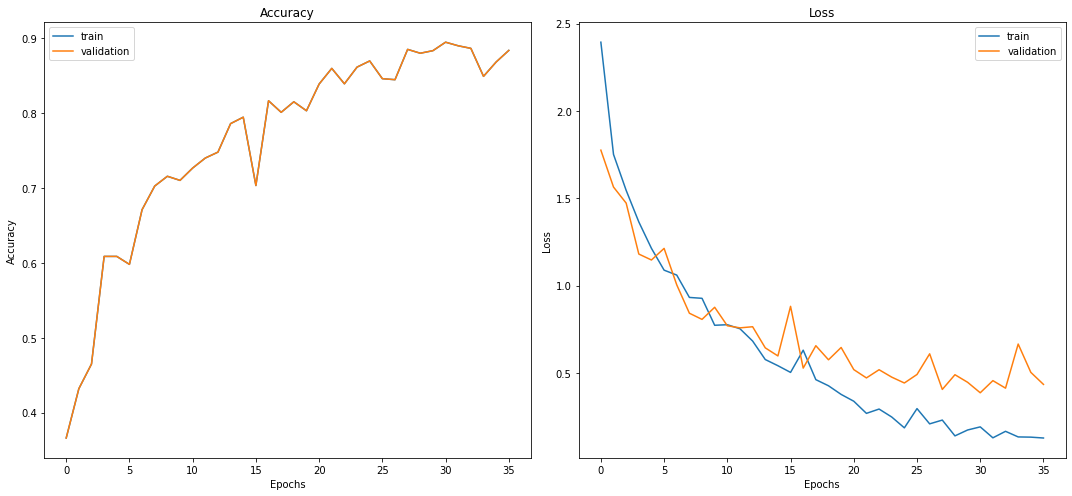

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['val_accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


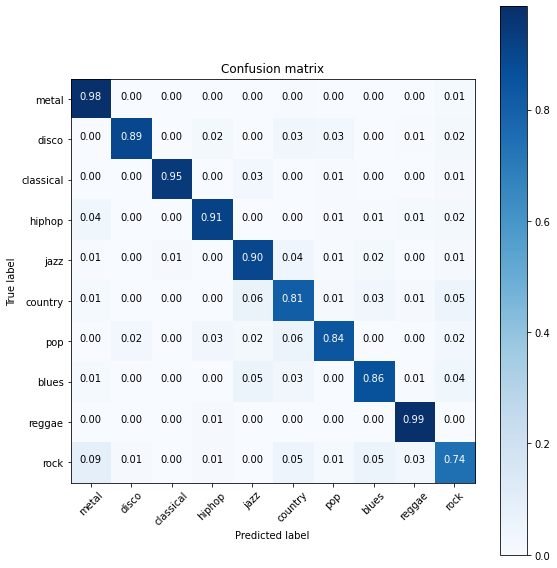

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)